In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import csv

In [78]:
# Define the low pass filter
cutoff_freq = 0.10
sampling_freq = 4.10

def lowpass_filter(dataframe):
    b, a = butter(5, 2*cutoff_freq/sampling_freq, btype='low', analog=False)
    return filtfilt(b, a, dataframe)

In [79]:
def analyse(file_path, nolimit=False):

    with open(file_path, 'r') as f:
        data = [row[0] for row in csv.reader(f)] 
    df = pd.DataFrame({'time': data, 'sensor': ['Hall' for x in data]})
    df['time'] = df['time'].apply(lambda x: int(x))

    # Crop the df
    df_filtered = df.iloc[::10]
    df = df_filtered[:-100]
    display(df)
    
    df = df[['time', 'sensor']]
    df = df.reset_index(drop=True)

    # Compute GPMs
    hall_times = list(df[df.sensor=='Hall'].time)

    for i in range(len(hall_times)-1):
        frequency = 1/(hall_times[i+1]-hall_times[i])*1e9
        if i==0: 
            df.loc[df.time>=0, 'hall_freq'] = frequency
            df.loc[df.time>=0, 'hall_GPM'] = frequency/7.5 * 0.264172
        df.loc[df.time>=hall_times[i], 'hall_freq'] = frequency
        df.loc[df.time>=hall_times[i], 'hall_GPM'] = frequency/7.5 * 0.264172

    # Low pass filer
    df['hall_GPM_filtered'] = lowpass_filter(df['hall_freq'])

    # Plot results
    plt.plot(list(df.time), list(df.hall_freq), alpha=0.3, label=f'Hall', color='green')
    plt.plot(list(df.time), list(df.hall_GPM_filtered), alpha=0.7, label=f'Hall filtered', color='blue')
    plt.title(file_path.split('/')[-1])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

,time,sensor
0,1609463419231893000,Hall
10,1609463419552857000,Hall
20,1609463419873608000,Hall
30,1609463420196024000,Hall
40,1609463420516960000,Hall
...,...,...
494510,1609476667931585000,Hall
494520,1609476668144093000,Hall
494530,1609476668356849000,Hall
494540,1609476668567772000,Hall


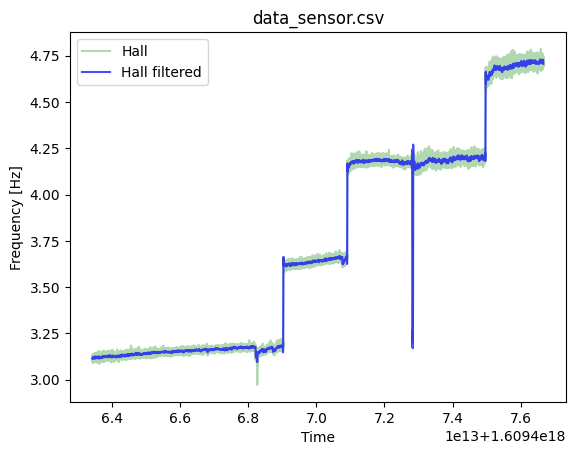

In [80]:
analyse(f'/Users/thomas/Desktop/data_sensor.csv')